## Neural Network Classification with PyTorch

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import requests
from pathlib import Path
from helper_function import accuracy_function
from timeit import default_timer as timer
from tqdm.auto import tqdm
import math

C:\Users\Chris\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data preparation

In [2]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

In [3]:
train_image, train_label = train_data[0]
test_image, test_label = test_data[0]

train_image, train_label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [4]:
batch_size = 32

train_dataloader = DataLoader(train_data, 
    batch_size = batch_size,
    shuffle = True
)

test_dataloader = DataLoader(test_data,
    batch_size = batch_size,
    shuffle = False
)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000256DA257070>, <torch.utils.data.dataloader.DataLoader object at 0x000002568C020D90>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [5]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### 2. Data visualization

In [6]:
class_name = train_data.classes

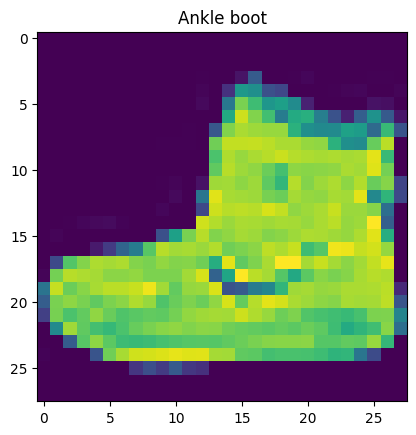

In [7]:
image, label = train_data[0]

plt.imshow(image.squeeze())
plt.title(class_name[label]);

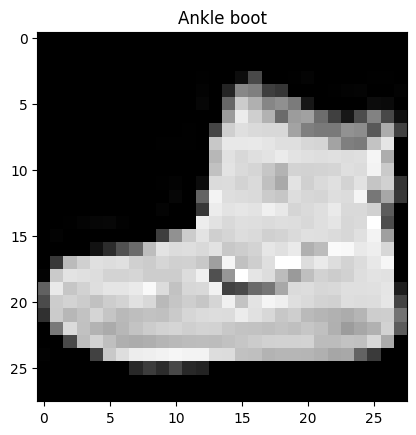

In [8]:
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_name[label]);

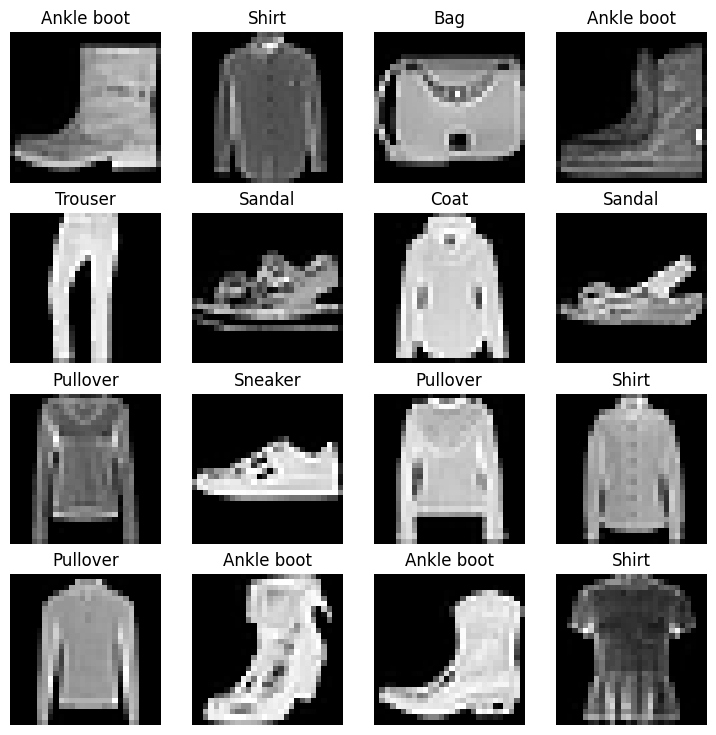

In [9]:
### Multi plotting
torch.manual_seed(42)

fig = plt.figure(figsize = (9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size = [1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap = "gray")
    plt.title(class_name[label])
    plt.axis(False);

### 3. Model building

Experiment what is happening after flattenning

In [10]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height * width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height * width]


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
# Model creation
class CustomModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

# Model creation with non-linear (relu)
class CustomModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape, out_features = hidden_unit),
            nn.ReLU(),
            nn.Linear(in_features = hidden_unit, out_features = output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)
    
# Create convolutional neural network model 
class CNNModel(nn.Module):
    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        
        self.first_block = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels = hidden_unit, 
                      kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_unit, out_channels = hidden_unit, 
                      kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.second_block = nn.Sequential(
            nn.Conv2d(hidden_unit, hidden_unit, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(hidden_unit, hidden_unit, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_unit * 7 * 7, 
                      out_features = output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.first_block(x)
#         print(x.shape)
        x = self.second_block(x)
#         print(x.shape)        
        x = self.classifier(x)
#         print(x.shape)
        
        return x

In [13]:
# Function creation
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    
    print(f"Train time on {device}: {total_time:.3f} seconds")
    
    return total_time

def model_training(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_function: torch.nn.Module,
                   optimizer: torch.optim.Optimizer, accuracy_function, device: torch.device = device):
    train_loss, train_accuracy = 0, 0
    model.to(device)
    
    for batch, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_function(y_pred, y)
        train_loss += loss
        train_accuracy += accuracy_function(y_true = y, y_pred = y_pred.argmax(dim = 1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_accuracy /= len(data_loader)
    
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy:.2f}%")

def model_testing(data_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_function: torch.nn.Module,
                  accuracy_function, device: torch.device = device):
    test_loss, test_accuracy = 0, 0
    model.to(device)
    
    model.eval()
    
    with torch.inference_mode(): 
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            
            test_pred = model(x)
            
            test_loss += loss_function(test_pred, y)
            test_accuracy += accuracy_function(y_true = y,
                y_pred = test_pred.argmax(dim = 1)
            )
        
        test_loss /= len(data_loader)
        test_accuracy /= len(data_loader)
        
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}%\n")

def model_evaluation(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, 
               loss_function: torch.nn.Module, accuracy_function, device: torch.device = device):
    loss, accuracy = 0, 0
    
    model.eval()
    
    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            loss += loss_function(y_pred, y)
            accuracy += accuracy_function(y_true = y, y_pred = y_pred.argmax(dim = 1))
        
        loss /= len(data_loader)
        accuracy /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, "model_loss": loss.item(), "model_accuracy": accuracy}

First model

In [14]:
torch.manual_seed(42)

first_model = CustomModelV1(input_shape = 784,
    hidden_units = 10,
    output_shape = len(class_name)
)

first_model.to("cpu")

CustomModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [15]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = first_model.parameters(), lr = 0.1)

In [16]:
torch.manual_seed(42)

# Initialize start timer
train_time_start = timer()

epoch_number = 4

# Start training and testing loop
for epoch in tqdm(range(epoch_number)):
    print(f"Epoch: {epoch + 1}\n-------")
    
    train_loss = 0
    
    for batch, (x, y) in enumerate(train_dataloader):
        # Start training mode
        first_model.train()
        
        # Forward pass
        y_pred = first_model(x)
        
        # Calculate loss
        loss = loss_function(y_pred, y)
        
        # Accumulatively add up the loss per epoch 
        train_loss += loss
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(x)} / {len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)
    
    test_loss, test_accuracy = 0, 0
    
    # Start testing mode
    first_model.eval()
    
    with torch.inference_mode():
        for x, y in test_dataloader:
            # Forward pass
            test_pred = first_model(x)
           
            # Calculate loss
            # Accumulatively add up the loss per epoch
            test_loss += loss_function(test_pred, y)

            # Calculate accuracy
            test_accuracy += accuracy_function(y_true = y, y_pred = test_pred.argmax(dim = 1))
        
        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)
        
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test accuracy: {test_accuracy:.2f}%\n")

# Calculate training time
# Intialize end timer
train_time_end = timer()
total_train_time_first_model = print_train_time(start = train_time_start, end = train_time_end,
    device = str(next(first_model.parameters()).device))

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 25%|██▌       | 1/4 [00:08<00:25,  8.49s/it]


Train loss: 0.59039 | Test loss: 0.50954, Test accuracy: 82.04%

Epoch: 2
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 50%|█████     | 2/4 [00:16<00:16,  8.36s/it]


Train loss: 0.47633 | Test loss: 0.47989, Test accuracy: 83.20%

Epoch: 3
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 75%|███████▌  | 3/4 [00:24<00:08,  8.23s/it]


Train loss: 0.45503 | Test loss: 0.47664, Test accuracy: 83.43%

Epoch: 4
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


100%|██████████| 4/4 [00:33<00:00,  8.31s/it]


Train loss: 0.44251 | Test loss: 0.46306, Test accuracy: 83.75%

Train time on cpu: 33.231 seconds


In [17]:
torch.manual_seed(42)

loss, accuracy = 0, 0

first_model.eval()

with torch.inference_mode():
    for x, y in test_dataloader:
        y_pred = first_model(x)

        loss += loss_function(y_pred, y)
        accuracy += accuracy_function(y_true = y, y_pred = y_pred.argmax(dim = 1))

    loss /= len(test_dataloader)
    accuracy /= len(test_dataloader)

print(f"First model`s evaluation result - Loss: {loss}, Accuracy: {round(accuracy, 2)}")

First model`s evaluation result - Loss: 0.4630562663078308, Accuracy: 83.75


In [18]:
torch.manual_seed(42)

first_model_result = model_evaluation(model = first_model, data_loader = test_dataloader,
    loss_function = loss_function, accuracy_function = accuracy_function, device = device
)

first_model_result

{'model_name': 'CustomModelV1',
 'model_loss': 0.4630562663078308,
 'model_accuracy': 83.74600638977635}

Second model

In [19]:
torch.manual_seed(42)

second_model = CustomModelV2(input_shape = 784, hidden_unit = 10,
    output_shape = len(class_name)
).to(device)

next(second_model.parameters()).device

device(type='cpu')

In [20]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = second_model.parameters(), lr = 0.1)

In [21]:
train_time_start = timer()

epoch_number = 3

for epoch in tqdm(range(epoch_number)):
    print(f"Epoch: {epoch + 1}\n---------")
    
    model_training(data_loader = train_dataloader, 
        model = second_model, 
        loss_function = loss_function,
        optimizer = optimizer,
        accuracy_function = accuracy_function
    )
    
    model_testing(data_loader = test_dataloader,
        model = second_model,
        loss_function = loss_function,
        accuracy_function = accuracy_function
    )

train_time_end = timer()

total_train_time_second_model = print_train_time(start = train_time_start, end = train_time_end, device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 1.05878 | Train accuracy: 62.19%


 33%|███▎      | 1/3 [00:08<00:16,  8.16s/it]

Test loss: 0.99506 | Test accuracy: 64.13%

Epoch: 2
---------
Train loss: 0.91331 | Train accuracy: 66.40%


 67%|██████▋   | 2/3 [00:16<00:08,  8.14s/it]

Test loss: 0.90508 | Test accuracy: 66.86%

Epoch: 3
---------
Train loss: 0.87981 | Train accuracy: 67.25%


100%|██████████| 3/3 [00:24<00:00,  8.23s/it]

Test loss: 0.89485 | Test accuracy: 66.47%

Train time on cpu: 24.686 seconds


Third model

In [22]:
torch.manual_seed(42)

third_model = CNNModel(input_shape = 1, hidden_unit = 10, 
    output_shape = len(class_name)).to(device)

third_model

CNNModel(
  (first_block): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (second_block): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [23]:
torch.manual_seed(42)

random_image = torch.randn(size = (32, 3, 64, 64))
test_image = random_image[0]

print(f"Image batch shape: {random_image.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [24]:
torch.manual_seed(42)

cnn_layer = nn.Conv2d(in_channels = 3, out_channels = 10,
    kernel_size = 3, stride = 1, padding = 0)
cnn_layer(test_image)

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

In [25]:
# Add extra dimension
test_image.unsqueeze(dim = 0).shape

torch.Size([1, 3, 64, 64])

In [26]:
cnn_layer(test_image.unsqueeze(dim = 0)).shape

torch.Size([1, 10, 62, 62])

In [27]:
torch.manual_seed(42)

cnn_layer_2 = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = (5, 5),
    stride = 2, padding = 0)

print("Before - ", cnn_layer(test_image.unsqueeze(dim = 0)).shape)
print("After - ", cnn_layer_2(test_image.unsqueeze(dim = 0)).shape)

Before -  torch.Size([1, 10, 62, 62])
After -  torch.Size([1, 10, 30, 30])


In [28]:
# Check cnn_layer_2 internal parameter
print(cnn_layer_2.state_dict())

OrderedDict([('weight', tensor([[[[ 0.0883,  0.0958, -0.0271,  0.1061, -0.0253],
          [ 0.0233, -0.0562,  0.0678,  0.1018, -0.0847],
          [ 0.1004,  0.0216,  0.0853,  0.0156,  0.0557],
          [-0.0163,  0.0890,  0.0171, -0.0539,  0.0294],
          [-0.0532, -0.0135, -0.0469,  0.0766, -0.0911]],

         [[-0.0532, -0.0326, -0.0694,  0.0109, -0.1140],
          [ 0.1043, -0.0981,  0.0891,  0.0192, -0.0375],
          [ 0.0714,  0.0180,  0.0933,  0.0126, -0.0364],
          [ 0.0310, -0.0313,  0.0486,  0.1031,  0.0667],
          [-0.0505,  0.0667,  0.0207,  0.0586, -0.0704]],

         [[-0.1143, -0.0446, -0.0886,  0.0947,  0.0333],
          [ 0.0478,  0.0365, -0.0020,  0.0904, -0.0820],
          [ 0.0073, -0.0788,  0.0356, -0.0398,  0.0354],
          [-0.0241,  0.0958, -0.0684, -0.0689, -0.0689],
          [ 0.1039,  0.0385,  0.1111, -0.0953, -0.1145]]],


        [[[-0.0903, -0.0777,  0.0468,  0.0413,  0.0959],
          [-0.0596, -0.0787,  0.0613, -0.0467,  0.0701],

In [29]:
# Shape of weight and bias within cnn_layer_2
print(f"cnn_layer_2 weight shape: \n{cnn_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\ncnn_layer_2 bias shape: \n{cnn_layer_2.bias.shape} -> [out_channels=10]")

cnn_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

cnn_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


In [30]:
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim = 0).shape}")

max_pool_layer = nn.MaxPool2d(kernel_size = 2)

test_image_through_cnn_layer = cnn_layer(test_image.unsqueeze(dim = 0))
print(f"Shape after going through cnn_layer(): {test_image_through_cnn_layer.shape}")

test_image_through_cnn_layer_and_max_pool = max_pool_layer(test_image_through_cnn_layer)
print(f"Shape after going through cnn_layer() and max_pool_layer(): {test_image_through_cnn_layer_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through cnn_layer(): torch.Size([1, 10, 62, 62])
Shape after going through cnn_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [31]:
torch.manual_seed(42)

random_tensor = torch.randn(size = (1, 1, 2, 2))

print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size = 2)
max_pool_tensor = max_pool_layer(random_tensor)

print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


In [32]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = third_model.parameters(), lr = 0.1)

In [33]:
train_time_start = timer()

epoch_number = 3

for epoch in tqdm(range(epoch_number)):
    print(f"Epoch: {epoch}\n---------")
    
    model_training(data_loader = train_dataloader, 
        model = third_model, 
        loss_function = loss_function,
        optimizer = optimizer,
        accuracy_function = accuracy_function,
        device = device
    )
    
    model_testing(data_loader = test_dataloader,
        model = third_model,
        loss_function = loss_function,
        accuracy_function = accuracy_function,
        device = device
    )

train_time_end = timer()
total_train_time = print_train_time(start = train_time_start, end = train_time_end, device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58034 | Train accuracy: 78.84%


 33%|███▎      | 1/3 [00:26<00:53, 26.63s/it]

Test loss: 0.42770 | Test accuracy: 84.66%

Epoch: 1
---------
Train loss: 0.35584 | Train accuracy: 87.22%


 67%|██████▋   | 2/3 [00:54<00:27, 27.28s/it]

Test loss: 0.34248 | Test accuracy: 87.85%

Epoch: 2
---------
Train loss: 0.31567 | Train accuracy: 88.66%


100%|██████████| 3/3 [01:22<00:00, 27.59s/it]

Test loss: 0.32724 | Test accuracy: 88.35%

Train time on cpu: 82.751 seconds


In [34]:
third_model_result = model_evaluation(
    model = third_model,
    data_loader = test_dataloader,
    loss_function = loss_function,
    accuracy_function = accuracy_function
)

third_model_result

{'model_name': 'CNNModel',
 'model_loss': 0.3272373378276825,
 'model_accuracy': 88.34864217252397}